In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error , mean_absolute_error,mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import warnings

In [2]:
data = pd.read_csv("ASIANPAINT-mock.csv")
data['inRs'] = data['inRs'].ffill()
train_size = int(len(data) * 0.8)
train, test = data['inRs'][:train_size], data['inRs'][train_size:]
# Initializing a dual variable
rho = 1.0  # Penalty parameter
u = 0.0
             

# Normalizing the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
test_scaled = scaler.transform(test.values.reshape(-1, 1))




In [3]:
# Prepare LSTM x and y values
def create_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

In [4]:
look_back = 1 # used for iterations over the dataset
X_train, y_train = create_dataset(train_scaled, look_back)
X_train = X_train.reshape((X_train.shape[0], look_back, 1))

X_test, y_test = create_dataset(test_scaled, look_back)
X_test = X_test.reshape((X_test.shape[0], look_back, 1))


In [5]:
#fit the LSTM model
model = Sequential()

model.add(LSTM(50, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
model.fit(X_train, y_train, epochs=30, batch_size=100, verbose=2)
# Generate LSTM predictions
#lstm_predictions = model.predict(X_test)

lstm_predictions = model.predict(X_train)
lstm_predictions = scaler.inverse_transform(lstm_predictions).flatten()

Epoch 1/30
9/9 - 4s - loss: 0.2416 - 4s/epoch - 436ms/step
Epoch 2/30
9/9 - 0s - loss: 0.2046 - 40ms/epoch - 4ms/step
Epoch 3/30
9/9 - 0s - loss: 0.1701 - 40ms/epoch - 4ms/step
Epoch 4/30
9/9 - 0s - loss: 0.1380 - 40ms/epoch - 4ms/step
Epoch 5/30
9/9 - 0s - loss: 0.1091 - 40ms/epoch - 4ms/step
Epoch 6/30
9/9 - 0s - loss: 0.0834 - 32ms/epoch - 4ms/step
Epoch 7/30
9/9 - 0s - loss: 0.0623 - 32ms/epoch - 4ms/step
Epoch 8/30
9/9 - 0s - loss: 0.0457 - 32ms/epoch - 4ms/step
Epoch 9/30
9/9 - 0s - loss: 0.0344 - 40ms/epoch - 4ms/step
Epoch 10/30
9/9 - 0s - loss: 0.0276 - 40ms/epoch - 4ms/step
Epoch 11/30
9/9 - 0s - loss: 0.0241 - 32ms/epoch - 4ms/step
Epoch 12/30
9/9 - 0s - loss: 0.0223 - 40ms/epoch - 4ms/step
Epoch 13/30
9/9 - 0s - loss: 0.0214 - 32ms/epoch - 4ms/step
Epoch 14/30
9/9 - 0s - loss: 0.0206 - 32ms/epoch - 4ms/step
Epoch 15/30
9/9 - 0s - loss: 0.0197 - 40ms/epoch - 4ms/step
Epoch 16/30
9/9 - 0s - loss: 0.0189 - 40ms/epoch - 4ms/step
Epoch 17/30
9/9 - 0s - loss: 0.0180 - 40ms/epoch 

In [6]:
# Fit ARIMA model
#arima_fit = ARIMA(train, order=(1, 0, 0)).fit()
arima_fit = ARIMA(train, order=(6,1,4)).fit()
arima_forecast = arima_fit.forecast(steps=len(test)-1)
aic = arima_fit.aic
bic = arima_fit.bic


#for d in range(2) :
#    for p in range(9) :
#      for q in range(9) :

#        fit=ARIMA(train,order=(p,d,q)).fit()
#        print("values  : ",p,d,q," :",fit.aic,"\n")

print(f"AIC: {aic}")# aic method akaike information criterion 
print(f"BIC: {bic}")# bic method bayesian information criterion
# Ensure that the lengths are consistent
test_length = len(test)
arima_forecast = arima_forecast[:test_length]  # Trim ARIMA forecast if too long
lstm_predictions = lstm_predictions[:test_length-1]  # Trim LSTM predictions if too long
print(" Lengths ",len(X_test),len(lstm_predictions))

AIC: 6912.277382091723
BIC: 6964.119900299171
 Lengths  205 205


c:\Users\venka\anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [7]:

print(f'Length of ARIMA forecast: {len(arima_forecast)}')
print(f'Length of LSTM predictions: {len(lstm_predictions)}')

# Calculate MSE
lstm_mse = mean_squared_error(test[look_back:], lstm_predictions)
arima_mse = mean_squared_error(test[look_back:], arima_forecast)
lstm_mae =mean_absolute_error(test[look_back:], lstm_predictions)
print(f'LSTM MSE: {lstm_mse}')
print(f'ARIMA MSE: {arima_mse}')
print(lstm_mae)
print(mean_absolute_error(test[look_back:],arima_forecast))

Length of ARIMA forecast: 205
Length of LSTM predictions: 205
LSTM MSE: 343887.1878275478
ARIMA MSE: 70953.71757389494
572.6204027129382
227.57888964237804


In [8]:
weight_arima = 1 / arima_mse
weight_lstm = 1 / lstm_mse
total_weight = weight_arima + weight_lstm
u += rho * (arima_forecast - lstm_predictions)

hybrid_forecast = ((arima_forecast * weight_arima + lstm_predictions * weight_lstm)) / total_weight
hybrid_mse = mean_squared_error(test[look_back:], hybrid_forecast)
print(hybrid_mse)

96290.489011343


In [9]:
num_iterations = 50  # Number of ADMM iterations
print("Initial ARIMA forecast range:", np.min(arima_forecast), np.max(arima_forecast))
print("Initial LSTM forecast range:", np.min(lstm_predictions), np.max(lstm_predictions))

z = np.zeros_like(lstm_predictions)
u = np.zeros_like(lstm_predictions)

with warnings.catch_warnings():
 warnings.simplefilter("ignore")
 # Step 1: Update ARIMA forecast (x)
 #arima_fit = ARIMA(train, order=(1, 0, 0)).fit()
 arima_fit = ARIMA(test, order=(6,1,9)).fit()
 #print(arima_fit.summary())
 arima_forecast = arima_fit.forecast(steps=len(test)-1)
    
 # Ensure ARIMA forecast length matches test length
 arima_forecast = np.pad(arima_forecast, (0, max(0, len(test) - len(arima_forecast)-1)), mode='constant')[:len(test)]
 arima_forecast = arima_fit.forecast()
 arima_forecast = arima_fit.forecast(steps=len(test)-1)
    
# Step 2: Update LSTM forecast (y)
lstm_predictions = model.predict(X_train[-len(test):])
lstm_predictions = scaler.inverse_transform(lstm_predictions).flatten()
    
# Ensure LSTM forecast length matches test length
lstm_predictions = lstm_predictions[:len(test)-1]


for iteration in range(num_iterations):
    #print(f"Iteration {iteration + 1}/{num_iterations}")
    
    hybrid_forecast = (lstm_predictions + arima_forecast  + rho * ( z - u )) / ( 2 + rho )
    z = np.maximum(0,hybrid_forecast + u)
    u = u  + hybrid_forecast  - z
    
    # Step 3: Update dual variable (u)
    #u += rho * (arima_forecast - lstm_predictions)
   
    # Step 4: Combine ARIMA and LSTM forecasts
    #hybrid_forecast = (arima_forecast + lstm_predictions + u) / 2
    
# Print progress
arima_mse = mean_squared_error(test[look_back:], arima_forecast)
lstm_mse = mean_squared_error(test[look_back:], lstm_predictions)
hybrid_mse = mean_squared_error(test[look_back:], hybrid_forecast)
#print(" Arima : ",arima_forecast,"\n")
#print(" LSTM : ",lstm_predictions,"\n")
#print(" Data : ",hybrid_forecast,"\n")
print(f'ARIMA MSE: {arima_mse}')
print(f'LSTM MSE: {lstm_mse}')
print(f'Hybrid Model MSE: {hybrid_mse}')
print(" Mean Absolute Error - Arima ",mean_absolute_error(test[look_back:],arima_forecast))
print(" Mean Absolute Error - LSTM ",mean_absolute_error(test[look_back:],lstm_predictions))
print(" Mean Absolute Error - Hybrid ",mean_absolute_error(test[look_back:],hybrid_forecast))
print(" Mean Absolute Percentage Error - Arima ",mean_absolute_percentage_error(test[look_back:],arima_forecast))
print(" Mean Absolute Percentage Error - LSTM ",mean_absolute_percentage_error(test[look_back:],lstm_predictions))
print(" Mean Absolute Percentage Error - Hybrid ",mean_absolute_percentage_error(test[look_back:],hybrid_forecast))

Initial ARIMA forecast range: 1437.3151215717078 1438.5472040796399
Initial LSTM forecast range: 960.0231 1204.6089
7/7 [==============================] - 0s 1ms/step
ARIMA MSE: 61103.08998696687
LSTM MSE: 131939.92307203024
Hybrid Model MSE: 37024.94568249491
 Mean Absolute Error - Arima  181.34900782236878
 Mean Absolute Error - LSTM  319.5074501000381
 Mean Absolute Error - Hybrid  177.35612800739565
 Mean Absolute Percentage Error - Arima  0.12496021358579731
 Mean Absolute Percentage Error - LSTM  0.1863224850411794
 Mean Absolute Percentage Error - Hybrid  0.10819646130451276


In [10]:
data['forecast'] = np.nan
forecast_start_index = len(train)
data.loc[forecast_start_index:forecast_start_index + len(hybrid_forecast) - 1, 'forecast'] = hybrid_forecast

print(data.head(len(train)+10))


data['lstm'] = np.nan
lstm_start_index = len(train)
data.loc[lstm_start_index:lstm_start_index + len(lstm_predictions) - 1, 'lstm'] = lstm_predictions

print(data.head(len(train)+10))
print(data)

           Date   Volume  Prev Close    Close     inRs  forecast
0    31-12-2015   526825      878.15  0.88355   883.55       NaN
1    01-01-2016   294006      883.55  0.87875   878.75       NaN
2    04-01-2016   709103      878.75  0.88080   880.80       NaN
3    05-01-2016  1372748      880.80  0.90065   900.65       NaN
4    06-01-2016  1716479      900.65  0.88640   886.40       NaN
..          ...      ...         ...      ...      ...       ...
829  10-05-2019  3476379     1354.20  1.34105  1341.05       NaN
830  13-05-2019   862130     1341.05  1.33250  1332.50       NaN
831  14-05-2019  2167873     1332.50  1.32025  1320.25       NaN
832  15-05-2019   996276     1320.25  1.30595  1305.95       NaN
833  16-05-2019   726485     1305.95  1.30440  1304.40       NaN

[834 rows x 6 columns]
           Date   Volume  Prev Close    Close     inRs  forecast         lstm
0    31-12-2015   526825      878.15  0.88355   883.55       NaN          NaN
1    01-01-2016   294006      883.55  0.

In [11]:
testing = test[:len(hybrid_forecast)]
hybrid_mse = mean_squared_error(testing, hybrid_forecast)
print(f'Hybrid Model MSE: {hybrid_mse} ')


Hybrid Model MSE: 36793.869496548 


In [12]:
# Ensure the forecast length matches the length of the test set
forecast_start_index = len(train)
forecast_end_index = forecast_start_index + len(hybrid_forecast)

# Add the forecasts to the DataFrame
data['forecast'] = np.nan
#data.loc[forecast_start_index:forecast_end_index-1, 'forecast'] = hybrid_forecast

data.loc[forecast_start_index:forecast_end_index-1, 'forecast'] = lstm_predictions
# Print the updated DataFrame
print(data.head(len(train) + len(hybrid_forecast) + 5))
print(data.tail())


            Date   Volume  Prev Close    Close     inRs     forecast  \
0     31-12-2015   526825      878.15  0.88355   883.55          NaN   
1     01-01-2016   294006      883.55  0.87875   878.75          NaN   
2     04-01-2016   709103      878.75  0.88080   880.80          NaN   
3     05-01-2016  1372748      880.80  0.90065   900.65          NaN   
4     06-01-2016  1716479      900.65  0.88640   886.40          NaN   
...          ...      ...         ...      ...      ...          ...   
1025  24-02-2020  1310832     1842.25  1.81895  1818.95  1358.553467   
1026  25-02-2020   897257     1818.95  1.82610  1826.10  1372.713989   
1027  26-02-2020  1909619     1826.10  1.82665  1826.65  1370.970825   
1028  27-02-2020  1643273     1826.65  1.84380  1843.80  1371.717773   
1029  28-02-2020  2964119     1843.80  1.79795  1797.95          NaN   

             lstm  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN  
...           .

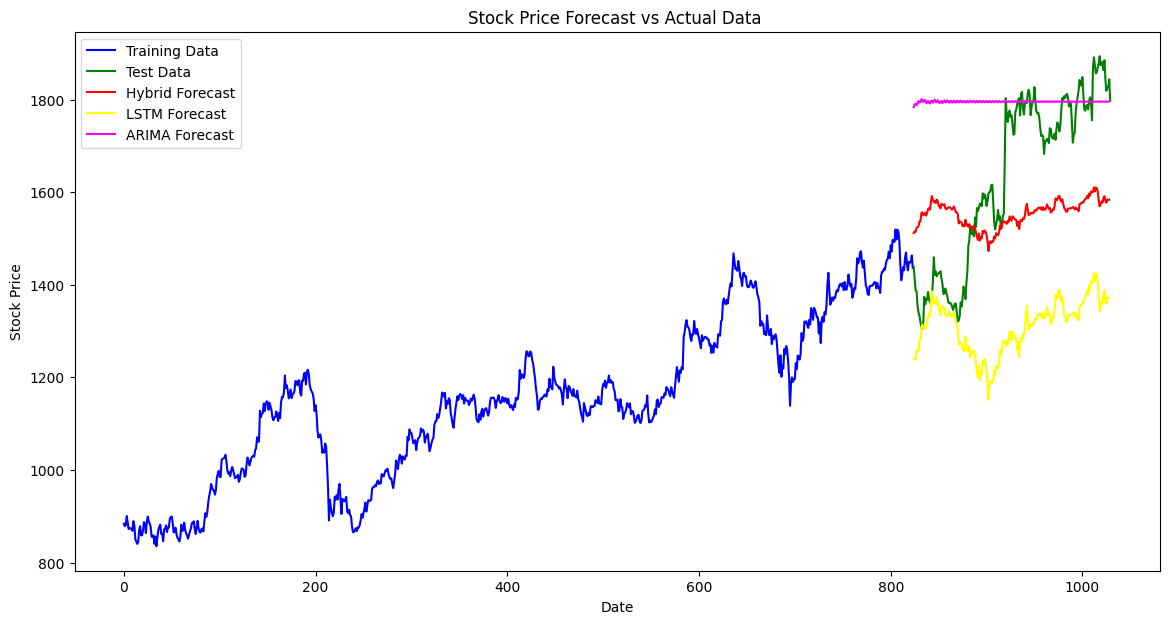

In [13]:


# Plot the actual vs forecasted values
plt.figure(figsize=(14, 7))
plt.plot(data.index[:len(train)], train, label='Training Data', color='blue')
plt.plot(data.index[len(train):len(train)+1 + len(hybrid_forecast)], test, label='Test Data', color='green')
plt.plot(data.index[len(train):len(train) + len(hybrid_forecast)], hybrid_forecast, label='Hybrid Forecast', color='red')
plt.plot(data.index[len(train):len(train) + len(lstm_predictions)], lstm_predictions, label='LSTM Forecast', color='yellow')
plt.plot(data.index[len(train):len(train) + len(arima_forecast)], arima_forecast, label='ARIMA Forecast', color='magenta')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Forecast vs Actual Data ')
plt.legend()
plt.show()


824 205 205 205


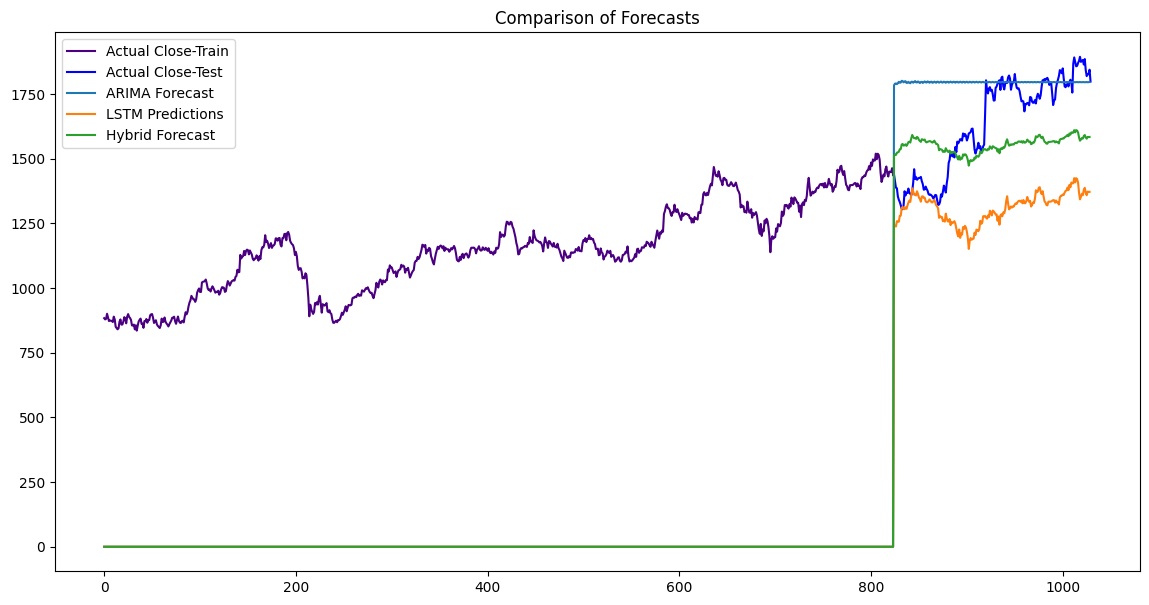

In [14]:
plt.figure(figsize=(14, 7))
#plt.plot(train[look_back:], label='Actual Sales')
plt.plot(train,label='Actual Close-Train',color='indigo')
plt.plot(test,label='Actual Close-Test',color='blue')
print(len(train),len(arima_forecast),len(lstm_predictions),len(hybrid_forecast))
arima_list = []

for i in range(len(train)) :
    arima_list.append(0)
for i in range(len(arima_forecast)) : 

    arima_list.append(arima_forecast[len(test)+len(train)+i])

lstm_list = []
for i in range(len(train)) :
    lstm_list.append(0)
for i in range(len(lstm_predictions)) : 
    lstm_list.append(lstm_predictions[i])
plt.plot(arima_list, label='ARIMA Forecast')
plt.plot(lstm_list, label='LSTM Predictions')

hybrid_list = []
for i in range(len(train)) :
    hybrid_list.append(0)
for i in range(len(hybrid_forecast)) : 
    hybrid_list.append(hybrid_forecast[len(train)+len(test)+i])
plt.plot(hybrid_list, label='Hybrid Forecast')


plt.legend()
plt.title('Comparison of Forecasts')
plt.show()
